In [2]:
!wget https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

--2024-04-18 23:50:10--  https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857427 (1.8M) [text/plain]
Saving to: ‘test.csv.1’

test.csv.1          100%[===================>]   1.77M  --.-KB/s    in 0.08s   

2024-04-18 23:50:10 (21.0 MB/s) - ‘test.csv.1’ saved [1857427/1857427]



In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string

stemmer = PorterStemmer()

def preprocess_text(text):
    punctuations = "!()-[]{};:'\',<>./?@#$%^&*_~"
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    for x in text:
        if x in punctuations:
            text = text.replace(x, " ")
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

data_path = './test.csv'
df = pd.read_csv(data_path, names=['class', 'title', 'description'])
data = df['description'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1 Word Prediction with Word2Vec and LSTM

In [4]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences

def text_to_vectors(text, word_vectors, include_stop_words=True):
    words = text.split()
    vectors = []
    for word in words:
        if include_stop_words or word not in ENGLISH_STOP_WORDS:
            if word in word_vectors:
                vectors.append(word_vectors[word])
            else:
                vectors.append(np.zeros(100))
    return np.array(vectors)

model = Word2Vec([d.split() for d in data], vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv


X = []
y = []
for d in data:
    vectors = text_to_vectors(d, word_vectors, include_stop_words=True)
    for i in range(len(vectors) - 102):
        X.append(vectors[i:i+100])
        y.append(vectors[i+100:i+102])

X = np.array(X)
y = np.array(y)

X_known = X[:, :-2, :]
y_unknown = y[:, -2:, :]

X_known = pad_sequences(X_known, maxlen=100, padding='post', dtype='float32')
y_unknown = pad_sequences(y_unknown, maxlen=2, padding='post', dtype='float32')

In [5]:
model_tanh = Sequential()
model_tanh.add(LSTM(200, activation='tanh', input_shape=(100, 100)))
model_tanh.add(RepeatVector(2))
model_tanh.add(LSTM(200, activation='tanh', return_sequences=True))
model_tanh.add(TimeDistributed(Dense(100)))
model_tanh.compile(optimizer='adam', loss='mse')

model_tanh.fit(X_known, y_unknown, epochs=10, batch_size=64, verbose=1)

x_input = X_known[0].reshape((1, 100, 100))
yhat_tanh = model_tanh.predict(x_input, verbose=0)
print(yhat_tanh)

Epoch 1/10
3/3 [==============================] - 5s 204ms/step - loss: 0.2457
Epoch 2/10
3/3 [==============================] - 1s 333ms/step - loss: 0.1717
Epoch 3/10
3/3 [==============================] - 1s 358ms/step - loss: 0.1167
Epoch 4/10
3/3 [==============================] - 1s 198ms/step - loss: 0.0987
Epoch 5/10
3/3 [==============================] - 1s 201ms/step - loss: 0.0966
Epoch 6/10
3/3 [==============================] - 1s 199ms/step - loss: 0.0930
Epoch 7/10
3/3 [==============================] - 1s 197ms/step - loss: 0.0910
Epoch 8/10
3/3 [==============================] - 1s 198ms/step - loss: 0.0901
Epoch 9/10
3/3 [==============================] - 1s 208ms/step - loss: 0.0871
Epoch 10/10
3/3 [==============================] - 1s 208ms/step - loss: 0.0870
[[[-0.4233026   0.3184873   0.3433965   0.13935421 -0.22806258
   -0.62143505  0.226518    1.0733559  -0.5124275  -0.30106166
   -0.23435201 -0.6103483   0.02230454  0.34422925  0.19678707
   -0.3722586   0.28

In [8]:
model_relu = Sequential()
model_relu.add(LSTM(200, activation='relu', input_shape=(100, 100)))
model_relu.add(RepeatVector(2))
model_relu.add(LSTM(200, activation='relu', return_sequences=True))
model_relu.add(TimeDistributed(Dense(100)))
model_relu.compile(optimizer='adam', loss='mse')

model_relu.fit(X_known, y_unknown, epochs=10, batch_size=64, verbose=1)

x_input = X_known[0].reshape((1, 100, 100))
yhat_relu = model_relu.predict(x_input, verbose=0)
print(yhat_relu)

Epoch 1/10
3/3 [==============================] - 4s 201ms/step - loss: 0.2518
Epoch 2/10
3/3 [==============================] - 1s 197ms/step - loss: 1341.1727
Epoch 3/10
3/3 [==============================] - 1s 192ms/step - loss: 0.2213
Epoch 4/10
3/3 [==============================] - 1s 188ms/step - loss: 0.2255
Epoch 5/10
3/3 [==============================] - 1s 194ms/step - loss: 0.2228
Epoch 6/10
3/3 [==============================] - 1s 191ms/step - loss: 0.2158
Epoch 7/10
3/3 [==============================] - 1s 194ms/step - loss: 0.2052
Epoch 8/10
3/3 [==============================] - 1s 194ms/step - loss: 0.1898
Epoch 9/10
3/3 [==============================] - 1s 193ms/step - loss: 0.1674
Epoch 10/10
3/3 [==============================] - 1s 196ms/step - loss: 0.1458
[[[-0.2986055   0.26447442  0.41001874  0.15365261 -0.17033312
   -0.48420882  0.0808064   0.6317255  -0.41580975 -0.14381361
   -0.33540934 -0.6563985   0.1328984   0.50584084  0.26199996
   -0.37804186  0

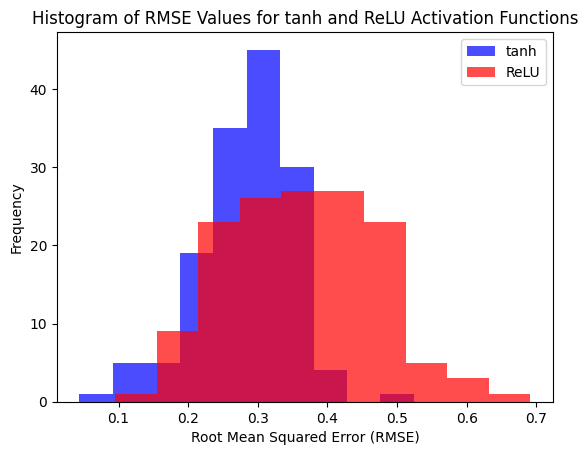

In [9]:
from sklearn.metrics import mean_squared_error

rmse_values_tanh = []
rmse_values_relu = []

for i in range(len(y_unknown)):
    x_input = X_known[i].reshape((1, 100, 100))
    y_true = y_unknown[i]
    yhat_tanh = model_tanh.predict(x_input, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_true, yhat_tanh[0]))
    rmse_values_tanh.append(rmse)

for i in range(len(y_unknown)):
    x_input = X_known[i].reshape((1, 100, 100))
    y_true = y_unknown[i]
    yhat_relu = model_relu.predict(x_input, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_true, yhat_relu[0]))
    rmse_values_relu.append(rmse)

import matplotlib.pyplot as plt
plt.hist(rmse_values_tanh, bins=10, color='blue', alpha=0.7, label='tanh')
plt.hist(rmse_values_relu, bins=10, color='red', alpha=0.7, label='ReLU')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.ylabel('Frequency')
plt.title('Histogram of RMSE Values for tanh and ReLU Activation Functions')
plt.legend()
plt.show()

RMSE: the lower the better.

Hence using tanh as the activation function is better.


In [10]:
word_vector_1 = yhat_tanh[0, 0, :]
word_vector_2 = yhat_tanh[0, 1, :]

closest_words_1 = word_vectors.similar_by_vector(word_vector_1, topn=5)
closest_words_2 = word_vectors.similar_by_vector(word_vector_2, topn=5)

print("Closest words to the first predicted word-vector:")
print(closest_words_1)

print("Closest words to the second predicted word-vector:")
print(closest_words_2)

Closest words to the first predicted word-vector:
[('due', 0.9972541332244873), ('terrorist', 0.9971428513526917), ('hard', 0.997104823589325), ('long', 0.9970925450325012), ('made', 0.9970619082450867)]
Closest words to the second predicted word-vector:
[('ani', 0.9964163303375244), ('him', 0.9962113499641418), ('player', 0.9961978197097778), ('right', 0.9961594939231873), ('where', 0.996145486831665)]


In [16]:
longest_doc_index = max(range(len(data)), key=lambda index: len(data[index].split()))
longest_doc = data[longest_doc_index]
print("Longest doc:")
print(longest_doc)

Longest doc:
the british depart for educ and skill dfe recent launch a music manifesto campaign with the ostens intent of educ the next gener of british musician unfortun they also team up with the music industri emi and variou artist to make thi popular emi ha appar negoti their end well so that children in our school will now be indoctrin about the illeg of download musicth ignor and audac of thi got to me a littl so i wrote an open letter to the dfe about it unfortun it pedant as i suppos you have to be when write to gover repres but i hope you find it use and perhap feel inspir to do someth similar if or when the same thing ha happen in your area


In [19]:
vectors_d = text_to_vectors(longest_doc, word_vectors, include_stop_words=True)
if len(vectors_d) < 100:
    vectors_d = pad_sequences([vectors_d], maxlen=100, padding='post', dtype='float32')[0]
else:
    vectors_d = vectors_d[-100:]

x_input_d = np.array([vectors_d])
yhat_d = model_tanh.predict(x_input_d)

predicted_vector_1 = yhat_d[0, 0]
predicted_vector_2 = yhat_d[0, 1]

closest_word_1 = word_vectors.similar_by_vector(predicted_vector_1, topn=1)[0][0]
closest_word_2 = word_vectors.similar_by_vector(predicted_vector_2, topn=1)[0][0]

print("Predicted words for longest_doc:", closest_word_1, closest_word_2)

1/1 [==============================] - 0s 152ms/step
Predicted words for longest_doc: terrorist ani


# 2 Word Prediction with Transformers

In [ ]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from transformers import pipeline
model = pipeline('fill-mask', model='bert-base-uncased', device=0)

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
model2 = AutoModelForCausalLM.from_pretrained("gpt2")
model2.to('cuda')  # Move the model to GPU

def pred_gpt2(seq):
    inputs = tokenizer(seq, return_tensors="pt").to('cuda')
    with torch.no_grad():
        logits = model2(**inputs).logits[:, -1, :]
    pred_id = torch.argmax(logits).item()
    pred_word = tokenizer.decode([pred_id])
    return pred_word.strip()

def pred_bert(seq):
    pred = model(f"{seq} [MASK]")
    return pred[0]['token_str']

def predict(f, d):
    wds = d.split()
    if len(wds) > 1:
        seq = ' '.join(wds[:-1])
        last = wds[-1]
        pred = f(seq)
        return pred == last
    return False

count = 0
for d in data:
    if predict(pred_bert, d):
        count += 1

print(f"BERT Accuracy: {count / len(data)}")

count = 0
for d in data:
    if predict(pred_gpt2, d):
        count += 1

print(f"GPT2 Accuracy: {count / len(data)}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERT Accuracy: 0.002763157894736842
GPT2 Accuracy: 0.06342105263157895


#2 Word Prediction with Transformers - EXTRA CREDIT

In [ ]:
import matplotlib.pyplot as plt
import gensim.downloader
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(word1, word2):
    if word1 in word2vec_model and word2 in word2vec_model:
        embedding1 = word2vec_model[word1]
        embedding2 = word2vec_model[word2]
        similarity = cosine_similarity([embedding1], [embedding2])[0][0]
        return similarity
    else:
        return 0

word2vec_model = gensim.downloader.load('glove-twitter-25')

cosine_similarities_bert = []
cosine_similarities_gpt2 = []

for d in data:
  wds = d.split()
  if len(wds) > 1:
    seq = ' '.join(wds[:-1])
    actual_word = wds[-1]
    last = wds[-1]
    predicted_word_bert = pred_bert(seq)
    predicted_word_gpt2 = pred_gpt2(seq)
    cosine_similarity_bert = compute_cosine_similarity(actual_word, predicted_word_bert)
    cosine_similarity_gpt2 = compute_cosine_similarity(actual_word, predicted_word_gpt2)
    cosine_similarities_bert.append(cosine_similarity_bert)
    cosine_similarities_gpt2.append(cosine_similarity_gpt2)

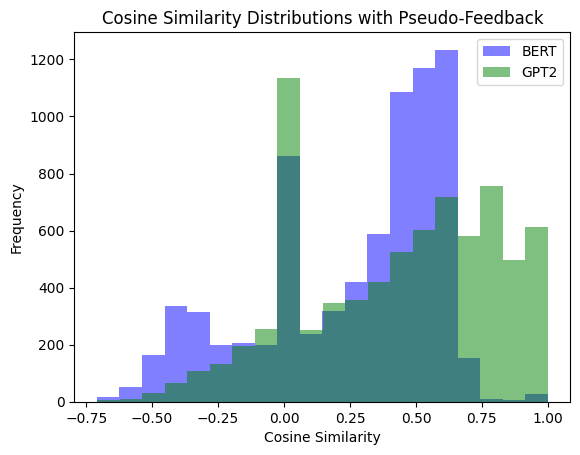

In [6]:
plt.hist(cosine_similarities_bert, bins=20, alpha=0.5, color='blue', label='BERT')
plt.hist(cosine_similarities_gpt2, bins=20, alpha=0.5, color='green', label='GPT2')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Cosine Similarity Distributions with Pseudo-Feedback')
plt.legend()
plt.show()

Though there are many BERT predictions getting around 50% cosine similarity,
the overall performance of GPT2 is better than BERT.


#3 Topic Modeling - Multinomial Probabilistic Model and LDA

In [ ]:
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
texts = data.apply(gensim.utils.simple_preprocess)
D1 = corpora.Dictionary(texts)
corpus = [D1.doc2bow(text) for text in texts]

In [ ]:
lda_model = gensim.models.LdaModel(corpus, num_topics=10, id2word=D1, passes=100)

In [ ]:
print(f"Top terms for topic {0}:", lda_model.show_topic(0, topn=5))

Top terms for topic 0: [('bad', 0.011046415), ('traffic', 0.010491124), ('crew', 0.008400247), ('liverpool', 0.008054136), ('earthquak', 0.007894368)]


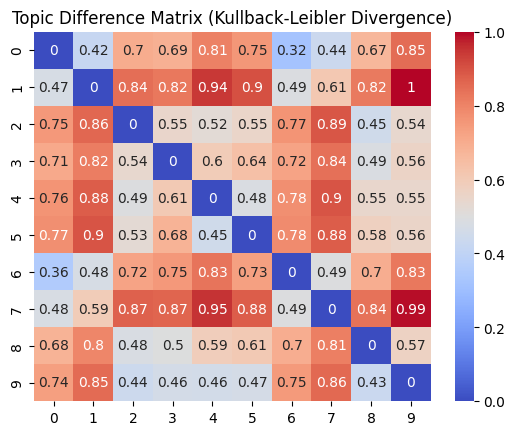

(array([[0.        , 0.42115493, 0.70145146, 0.69054656, 0.80671868,
        0.7541959 , 0.31700909, 0.43635312, 0.66801693, 0.84919915],
       [0.47428414, 0.        , 0.8442732 , 0.82499117, 0.94184151,
        0.90312173, 0.48952812, 0.60946598, 0.82310203, 1.        ],
       [0.75333769, 0.8628006 , 0.        , 0.55073962, 0.52085811,
        0.55176998, 0.76542626, 0.89243147, 0.44976511, 0.54018099],
       [0.70763312, 0.81534141, 0.54204067, 0.        , 0.59703461,
        0.63870113, 0.72272327, 0.83993002, 0.48724672, 0.56219004],
       [0.76432386, 0.88061594, 0.49331424, 0.6058934 , 0.        ,
        0.48448692, 0.77522995, 0.89687807, 0.54656898, 0.54667101],
       [0.77447191, 0.89622984, 0.52627451, 0.68083206, 0.45217522,
        0.        , 0.78316273, 0.87989523, 0.57624022, 0.55833261],
       [0.35533338, 0.47630727, 0.72287821, 0.75065426, 0.83489998,
        0.73080527, 0.        , 0.49475301, 0.69556479, 0.82709975],
       [0.47698659, 0.59493612, 0.874683

In [ ]:
topic_diff = lda_model.diff(lda_model, distance='kullback_leibler', num_words=50)

sns.heatmap(topic_diff[0], annot=True, cmap='coolwarm')
plt.title("Topic Difference Matrix (Kullback-Leibler Divergence)")
plt.show()

print(topic_diff)

# 4 EXTRA CREDIT - Logistic Regression for Learning to Rank with PageRank, HITS, and TF-IDF

In [20]:
import requests
from bs4 import BeautifulSoup

base_url = 'https://en.wikinews.org'
response = requests.get(f'{base_url}/wiki/Main_Page')
soup = BeautifulSoup(response.text, 'html.parser')

links = soup.find_all('a', href=True)
article_links = [link['href'] for link in links if '/wiki/' in link['href'] and 'Main_Page' not in link['href']]
article_links = list(dict.fromkeys(article_links))[:15]

pages = {}

for link in article_links:
    try:
      article_response = requests.get(f'{base_url}{link}')
      article_soup = BeautifulSoup(article_response.text, 'html.parser')
      content = article_soup.get_text()
      pages[link] = {'text': content, 'label': 0}
    except:
      continue

In [28]:
pages['/wiki/Wikinews:Breaking_news']['label'] = 1
pages['/wiki/Wikinews:Audio_Wikinews']['label'] = 1
pages['/wiki/Wikinews:Social_media']['label'] = 1
pages['/wiki/Wikinews:Featured_articles']['label'] = 1
pages['/wiki/Wikinews:Internet_Relay_Chat']['label'] = 1

for k in pages:
    pages[k]['text'] = preprocess_text(pages[k]['text'])

In [32]:
indices = list(pages)
print(indices)

['/wiki/Wikinews:Introduction', '/wiki/Wikinews:Copyright', '/wiki/Wikinews:Newsroom', '/wiki/Wikinews:Breaking_news', '/wiki/Wikinews:Audio_Wikinews', '/wiki/Wikinews:Social_media', '/wiki/Wikinews:Internet_Relay_Chat', '/wiki/Wikinews:Featured_articles', '/wiki/Iran_launches_missiles_and_drones_at_Israel', '/wiki/Wikinews:ML']


In [33]:
import networkx as nx

G = nx.DiGraph()

links = {
    0: [1, 3],
    1: [2],
    2: [0],
    3: [2],
    4: [5],
    5: [6],
    6: [7, 8],
    7: [9],
    8: [],
    9: [0]
}

for src, targets in links.items():
    for target in targets:
        G.add_edge(src, target)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

hubs, authorities = nx.hits(G)
pagerank_scores = nx.pagerank(G)

page_texts = [pages[indices[i]]['text'] for i in range(10)]

vectorizer = TfidfVectorizer(vocabulary=['twitter', 'client', 'blog', 'post', 'social', 'site'], stop_words='english')
tfidf_matrix = vectorizer.fit_transform(page_texts)
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=1).A.flatten()

result = {
    'PageID': list(range(10)),
    'Relevant': [1, 0, 0, 1, 1, 1, 1, 0, 1, 0],
    'PageRankScore': [pagerank_scores[i] for i in range(10)],
    'HITSScore': [authorities[i] for i in range(10)],
    'TF-IDFScore': tfidf_scores
}

df = pd.DataFrame(result)
df.set_index('PageID', inplace=True)
print(df)

        Relevant  PageRankScore     HITSScore  TF-IDFScore
PageID                                                    
0              1       0.267522  4.739637e-01     1.710013
1              0       0.131942 -1.183907e-01     1.000000
2              0       0.242547 -2.401948e-01     1.414208
3              1       0.131942 -1.183907e-01     1.387487
4              1       0.018247 -2.503215e-17     1.732044
5              1       0.033756 -2.503215e-17     1.922495
6              1       0.046940  3.003859e-16     1.671030
7              0       0.038196  5.015062e-01     1.414208
8              1       0.038196  5.015062e-01     1.000000
9              0       0.050713 -2.503215e-17     1.000000


In [54]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, f1_score, classification_report

df['Relevance'] = [1, 0, 0, 1, 1, 1, 1, 0, 1, 0]
X = df[['PageRankScore', 'HITSScore', 'TF-IDFScore']]
y = df['Relevance']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=59, stratify=y)
model = LogisticRegression()
model.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve, f1_score, auc

precision_train, recall_train, _ = precision_recall_curve(y_train, model.predict_proba(X_train)[:, 1])
precision_test, recall_test, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])

f1_train = f1_score(y_train, model.predict(X_train))
f1_test = f1_score(y_test, model.predict(X_test))

print("Training set:")
print("Precision:", precision_train)
print("Recall:", recall_train)
print("F1-score:", f1_train)

print("Test set:")
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_test)

Training set:
Precision: [0.66666667 0.6        0.75       1.         1.         1.
 1.        ]
Recall: [1.   0.75 0.75 0.75 0.5  0.25 0.  ]
F1-score: 0.8
Test set:
Precision: [0.5        0.66666667 0.5        1.         1.        ]
Recall: [1.  1.  0.5 0.5 0. ]
F1-score: 0.6666666666666666


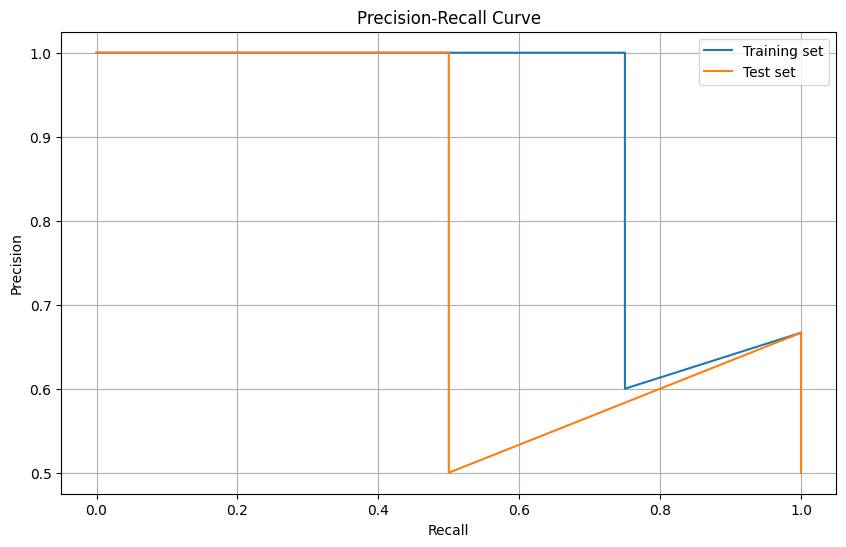

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(recall_train, precision_train, label='Training set')
plt.plot(recall_test, precision_test, label='Test set')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()